# Students
Bertoldo Damiano 000568813
Guija Valiente Tomás 000568600

# Video
Link to the video https://drive.google.com/file/d/1ZCmotjA8cjDY6OJsBGg64kghA_X_k5zO/view?usp=sharing

# Packages
In the next cell, I will include all packages installed for the whole project

In [1]:
#install.packages("cluster")
#install.packages("randomForest")
#install.packages("tree")
#install.packages("GGally")
#install.packages("skimr")
#install.packages("tidymodels")
#install.packages("keras")
#install.packages("ggplot2")
#install.packages("caret")
#install.packages("lazy")
#install.packages("xgboost")
#install.packages("caTools")

# Library imports

In [14]:
library(rpart)
library(lazy)
library(class)
library(xgboost)
library(caTools)
library(dplyr)
library(caret)


Attaching package: ‘dplyr’


The following object is masked from ‘package:xgboost’:

    slice


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice



# Seed set
Set the seed at the beginning for all the notebook

In [15]:
set.seed(2324)

# Task 1 - Data preprocessing and Feature selection
First of all, we just load the data

In [3]:
data <- read.csv("datasets/ProjectFiles/train_values.csv")
labels <- read.csv("datasets/ProjectFiles/train_labels.csv")
test_values <- read.csv("datasets/ProjectFiles/test_values.csv")

For visualization purposes we are going to show the first rows of *data* and *labels*. Additionally, we will verify whether the dataset contains any missing values.

In [ ]:
head(data)
head(labels)
if (!any(is.na(data))) {
    print("There are no missing values")
}

We are going also to plot the distribution of the Label dataset.

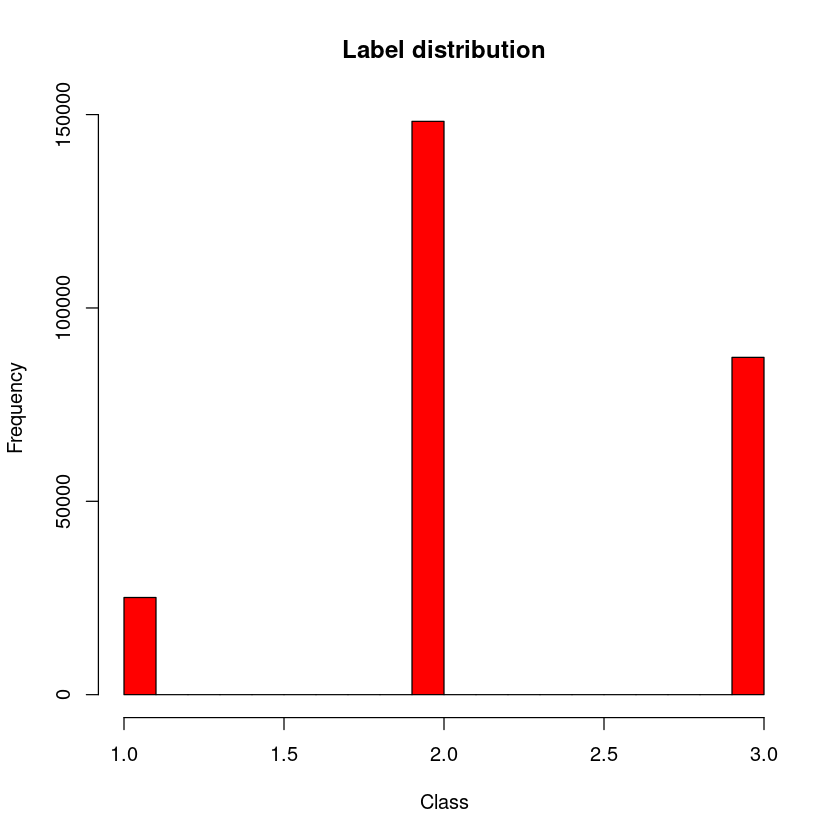

In [5]:
hist(as.numeric(labels[,2]), breaks = "Sturges", col = "red", xlab = "Class", ylab = "Frequency", main = "Label distribution")

## Data Preprocessing
Since multiple techniques for feature selection work with numbers we are going to transform each string column into an integer value. However, we will ensure that we maintain the original mapping.

In [6]:
# Define the function
convert_string_to_numeric <- function(data) {
  # Get the non numeric columns
  string_columns <- !sapply(data, is.numeric)
  string_data <- data[, string_columns]

  # Convert all non numeric values to numeric
  numeric_data <- lapply(string_data, function(x) {
    x <- as.factor(x)
    as.numeric(x)
  })

  # Now replace the non numeric columns in the original data frame by the recently created numeric columns
  numeric_data <- as.data.frame(numeric_data)
  data[, string_columns] <- numeric_data

  return(data)
}

We convert any values of the `data` dataset or `test_values` dataset from string into numeric.

In [7]:
data <- convert_string_to_numeric(data)
test_values <- convert_string_to_numeric(test_values)
head(data)
head(test_values)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
2,28830,8,900,2812,2,10,8,7,2,3,⋯,0,0,0,0,0,0,0,0,0,0
3,94947,21,363,8973,2,10,5,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
4,590882,22,418,10694,2,10,6,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
5,201944,11,131,1488,3,30,8,9,3,3,⋯,0,0,0,0,0,0,0,0,0,0
6,333020,8,558,6089,2,10,9,5,3,3,⋯,1,0,0,0,0,0,0,0,0,0


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,300051,17,596,11307,3,20,7,6,3,3,⋯,0,0,0,0,0,0,0,0,0,0
2,99355,6,141,11987,2,25,13,5,3,3,⋯,1,0,0,0,0,0,0,0,0,0
3,890251,22,19,10044,2,5,4,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
4,745817,26,39,633,1,0,19,3,3,3,⋯,0,0,1,0,0,0,0,0,0,0
5,421793,17,289,7970,3,15,8,7,3,3,⋯,0,0,0,0,0,0,0,0,0,0
6,871976,22,170,4029,1,55,4,3,3,3,⋯,0,0,0,0,0,0,0,0,0,0


We prepare some variables with the data needed for future steps.

In [8]:
# We won't count the building_id as a feature
features <- data[,-1]
response <- labels[, 2]
test_values_wo_id <- test_values[,-1]
# Merged_df will hold the data along with the damage_grade
merged_df <- merge(data, labels, by = "building_id")

## Feature selection
We are going to use the mRMR technique for feature selection. Out of the different techniques learned along the course, this one looked like the most appealing one. After taking a look at the different features, we figured out that just ranking the features according to the correlation with the output wouldn't be enough. It's easy to see that there are some features that will also be highly correlated to each other. This is the case of the different types of geo_level_id, and infrastructure related features. Also, there are quite few features that don't look that important at first sight.

In [9]:
selected<-c()
candidates<-1:ncol(features)
correlation<-abs(cor(features,response))
# mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
for (j in 1:ncol(features)) {

    redundancy_score<-numeric(length(candidates))
    if (length(selected)>0) {
        # Compute the correlation between the selected variables and the candidates on the training set
        cor_selected_candidates<-cor(features[,selected,drop=F],features[,candidates,drop=F], method = "spearman")
        # Compute the mean correlation for each candidate variable, across the selected variables
        redundancy_score<-apply(cor_selected_candidates,2,mean)
    }

    # mRMR: minimum Redundancy Maximum Relevancy
    mRMR_score<-correlation[candidates]-redundancy_score

    # Select the candidate variable that maximises the mRMR score
    selected_current<-candidates[which.max(mRMR_score)]
    selected<-c(selected,selected_current)

    # Remove the selected variables from the candidates
    candidates<-setdiff(candidates,selected_current)
}

# Since the indices are without the building_id, we add 1 so when we select the features on main dataset, we select the intended one
selected <- selected + 1
selected

[1] 17 21 25 24 10  5 12 16 11 27 22 18  7  3 14 31 32  2 28 23  6 19 29 15 33
[26] 26  9  4 39 34 35 36 37 20 13 38 30  8

This method gave us a ranking of the most important feautres, so the next step would be figuring out how many we should use. This will be done later on while training our models.

## Common methods

This method create all the metrics related to the confusion matrix.

In [10]:
get_metrics <- function (prediction, labels){
  # We compute the confusion matrix
  confusion_matrix <- table(prediction = prediction, labels = labels)

  # We assert the Precision, Recall, Specificity, F1 Score
  precision <- numeric(3)
  recall <- numeric(3)
  specificity <- numeric(3)
  f1_score <- numeric(3)

  for (class in 1:3) {
    TP <- sum(prediction == class & labels == class)
    FP <- sum(prediction == class) - TP
    TN <- sum(prediction != class & labels != class)
    FN <- sum(prediction != class & labels == class)
    precision[class] <- TP / (TP + FP)
    recall[class] <- TP / (TP + FN)
    specificity[class] <- TN / (TN + FP)
    f1_score[class] <- 2 * (precision[class] * recall[class]) / (precision[class] + recall[class])
  }

  # We assert the overall accuracy
  accuracy <- sum(prediction == labels) / length(labels)

  return(list(confusion_matrix = confusion_matrix, accuracy = accuracy, precision = precision, recall = recall, specificity = specificity, f1_score = f1_score))
}

# Task 2 - Model selection

## Decision Tree
The first model we will build is the decision tree. These can be very easily implemented with the library rpart. We will use our training data and split it into 2 sets, for training and for testing. This algorithm performs feature selection as it works, so no feature selection is actually needed in this case. Training the tree over a subset of feautres would reduce the dimensionality of the problem, but the training is still very fast using all features, and we actually got better results this way.

In [39]:
# Split the data into training and testing sets
n <- nrow(data)
train_indices <- sample(1:n, n * 0.8)
train_data <- features[train_indices, ]
train_labels <- labels[train_indices,2]

test_data <- features[-train_indices, ]
test_labels <- labels[-train_indices,2]

# Build the model
tree_model <- rpart(train_labels ~ ., data = train_data, method = "class")
# Make predictions on the test data
pred <- predict(tree_model, newdata = test_data, type = "class")

We can visualize the tree in a very readable format. As for accuracy, it gets up to 0.64.

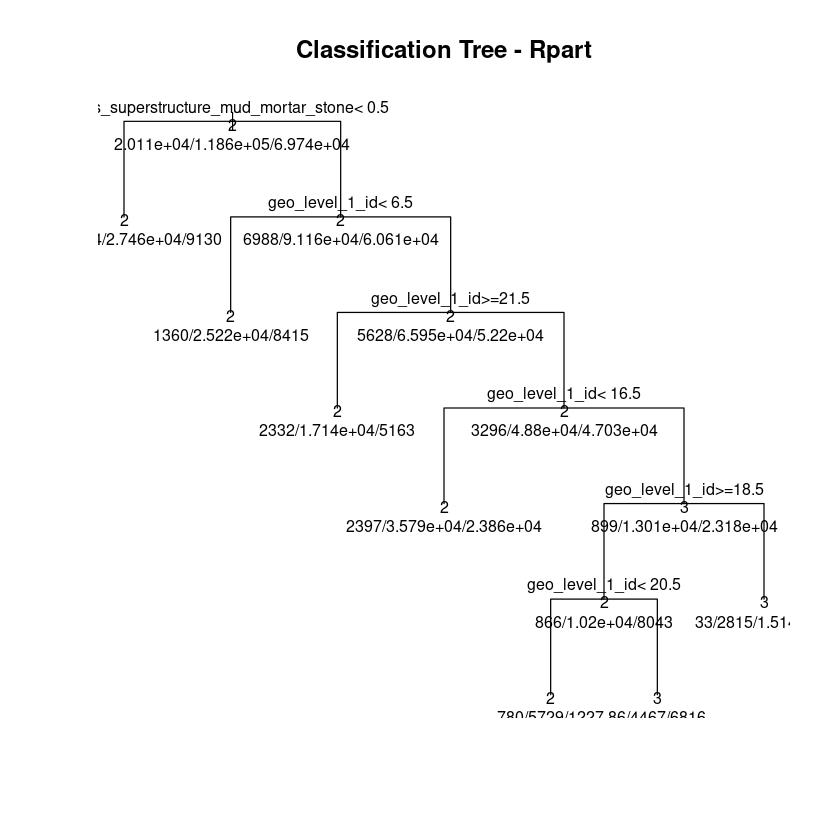

In [40]:
plot(tree_model, uniform=TRUE,
   main="Classification Tree - Rpart")
text(tree_model, use.n=TRUE, all=TRUE, cex=.8)

We can have some metrics on how precise the classification is.

          labels
prediction     1     2     3
         1     0     0     0
         2  4984 27822 11849
         3    26  1813  5627

[1] "Accuracy:  0.64175668156789"
[1] "Precision: "


[1]       NaN 0.6230433 0.7536834

[1] "Recall: "


[1] 0.0000000 0.9388223 0.3219844

[1] "Specificity: "


[1] 1.0000000 0.2514009 0.9469187

[1] "F1_score: "


[1]       NaN 0.7490106 0.4512068

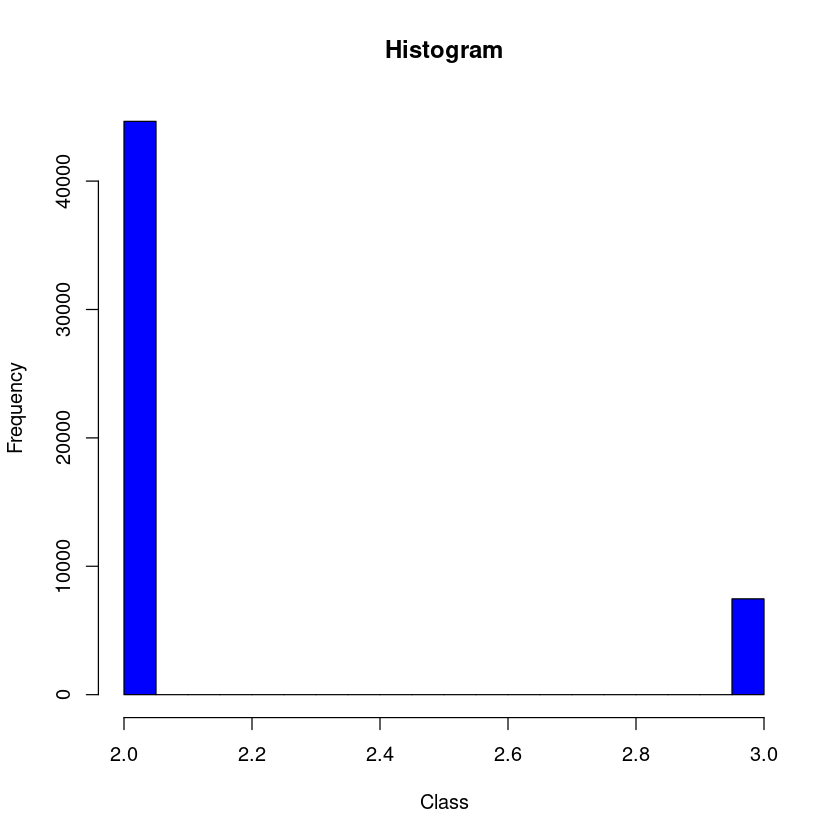

In [41]:
metrics <- get_metrics(pred, test_labels)
metrics$confusion_matrix
print(paste("Accuracy: ", metrics$accuracy))
print("Precision: ")
metrics$precision
print("Recall: ")
metrics$recall
print("Specificity: ")
metrics$specificity
print("F1_score: ")
metrics$f1_score

hist(as.numeric(pred), breaks = "Sturges", col = "blue", xlab = "Class", ylab = "Frequency", main = "Histogram")

A quite noticeable result from this model is that a damage_grade of level 1 is never predicted. The fact that the class 1 will never be predicted can be explained by the existing unbalance in the dataset. As we can see, there is not even a 10% of buildings with a damage grade of value 1. For this model it's not worthwhile predicting 1, since there aren't enough label to train on, but is still a good classifier for the remaining two classes.

In [68]:
sum(labels$damage_grade == 1)/nrow(labels)
#The model never predicts damage = 1, which makes sense since there are very little cases

[1] 0.09640792

## Random forest
For our next model, we decided create a random forest. In order to compare how this type of model behaves with different numbers of trees, we will build them manually. That way, instead of creating a new random forest each time, we can just keep adding trees and see how the performance of the model varies.


In [16]:
# Function used to get the majority vote
majority <- function(x) {
  table <- table(x)
  maj <- as.numeric(names(table)[which.max(table)])
  return(maj)
}

First, we create a random forest using 10 trees as a starting point. Then we iterate adding either 1 or 2 trees each time. We avoid having a multiple of 3 number of trees to prevent ties, since the task is to classify over 3 different classes. We save the accuracy of each random forest, and then plot them for comparison.

In [24]:
# We take all numbers from 11 to 20 except from the multiples of 3
n_trees <- c(11:20)
n_trees <- n_trees[n_trees %% 3 != 0]

# This array will store the accuracy of the random forest for different numbers of trees
rf_results <- numeric(length(n_trees))

# We take a big enough subset of features for the trees to branch correctly, but low enough to allow variety in the resulting trees.
features_per_tree <- 20

idx <- sample(1:nrow(features))
split <- floor(nrow(features) - nrow(features)/8)

Y_trees <- numeric()

# Creating an initial random forest of size 10
 for(i in 1:10){
    selected_features <- sample(1:(ncol(features)),features_per_tree)

    #Take the group as a hold out or train data set with bootstrap for each tree
    bootstrap_idx <- sample(1:split,replace = T)
    train_data <- features[idx[bootstrap_idx], selected_features]
    train_labels <- response[idx[bootstrap_idx]]

    #Take the remaining groups as a test data set
    test_data <- features[idx[(split+1):nrow(features)], selected_features]

    model <- rpart(train_labels ~ ., method="class",data=train_data)
    Y_pred <- predict(model, test_data, type = "class")

    #Store the prediction of each tree
    Y_trees <- cbind(Y_trees, as.numeric(Y_pred))
}

# Getting the results for a 10 tree random forest
rand_forest_pred <- apply(Y_trees,1,majority)
metrics <- get_metrics(rand_forest_pred, response[idx[(split+1):nrow(features)]])
rf_results[1] <- metrics$accuracy

i <- 2
for (n in n_trees){
    # Adding trees to the already existing random forest
    for (t in 3-n %% 3){
        selected_features <- sample(1:(ncol(features)),features_per_tree)

        #Take the group as a hold out or train data set with bootstrap for each tree
        bootstrap_idx <- sample(1:split,replace = T)
        train_data <- features[idx[bootstrap_idx], selected_features]
        train_labels <- response[idx[bootstrap_idx]]

        #Take the remaining groups as a test data set
        test_data <- features[idx[(split+1):nrow(features)], selected_features]

        model <- rpart(train_labels ~ ., method="class",data=train_data)
        Y_pred <- predict(model, test_data, type = "class")

        #Store the prediction of each tree
        Y_trees <- cbind(Y_trees, as.numeric(Y_pred))
    }

    # Saving metrics
    rand_forest_pred <- apply(Y_trees,1,majority)
    metrics <- get_metrics(rand_forest_pred, response[idx[(split+1):nrow(features)]])
    rf_results[i] <- metrics$accuracy
    i <- i + 1
}

Plot the outcome of the calculation

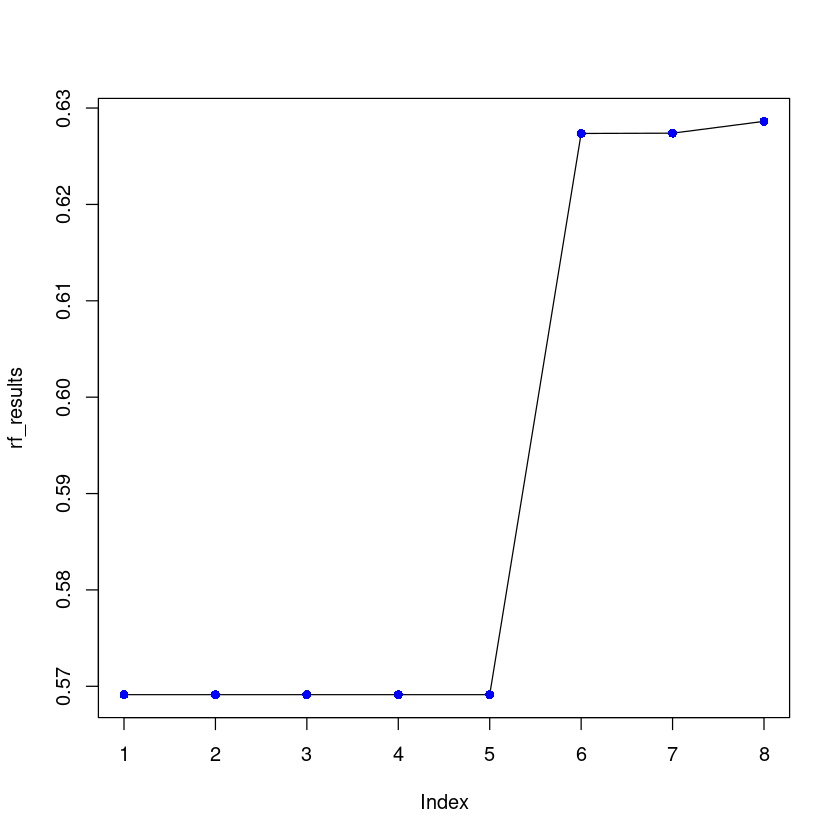

In [25]:
plot(rf_results, type = "l")
points(rf_results, col = "blue", pch = 16)

The accuracy we get is in no case better than the single decision tree, so we will discard this model classification. We choose to discard this method also because the result differ every run, so without consistency we couldn't have a reliable model.

## Lazy (K nearest neighbour)
For our last model, we are going to use the k nearest neighbour. For this model we will finally use our feature selection, that will highly improve the velocity of the algorithm. As we did with random forests, we will do a bit of parameter tuning by trying out different values for `k`, as well as for the amount of features used for the prediction, then saving the best result.


In [26]:
knn_train_indices <- sample(1:nrow(data), round(0.8*nrow(data)), replace = FALSE)
knn_train_set <- data[knn_train_indices, ]
knn_test_set <- data[-knn_train_indices, ]
head(knn_train_set)
head(knn_test_set)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
236238,628191,10,105,11675,2,10,8,7,3,3,⋯,0,0,0,0,0,0,0,0,0,0
85857,14530,6,453,11667,2,40,7,5,1,3,⋯,0,0,0,0,0,0,0,0,0,0
80795,17227,4,529,4713,2,0,8,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
47147,646622,17,303,9995,2,5,7,5,1,3,⋯,0,0,0,0,0,0,0,0,0,0
75038,1011352,6,1126,1110,2,0,9,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
144784,617319,26,36,7472,1,5,3,5,3,5,⋯,0,0,0,0,0,0,0,0,0,0


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
6,333020,8,558,6089,2,10,9,5,3,3,⋯,1,0,0,0,0,0,0,0,0,0
8,475515,20,323,12236,2,0,8,6,3,5,⋯,0,0,0,0,0,0,0,0,0,0
9,441126,0,757,7219,2,15,8,6,3,3,⋯,0,0,0,0,0,0,0,0,0,0
23,219578,10,90,11215,2,0,6,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
41,306024,10,825,7934,2,20,8,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
42,677028,7,728,5682,2,30,3,5,3,4,⋯,0,0,0,0,0,0,0,0,0,0


We will iterate through a different set of features, so we can assert which number of features gives the best outcome.

In [59]:
n_results <- numeric(5)

k <- 30
i <- 1
for (n in c(15,17,20,22,25)){
    knn_model <- knn(knn_train_set[,selected[1:n]], knn_test_set[,selected[1:n]], response[knn_train_indices], k = k)
    metrics <- get_metrics(knn_model, response[-knn_train_indices])
    n_results[i] <- metrics$accuracy
    i <- i+1
}

Plot the outcome of the calculation

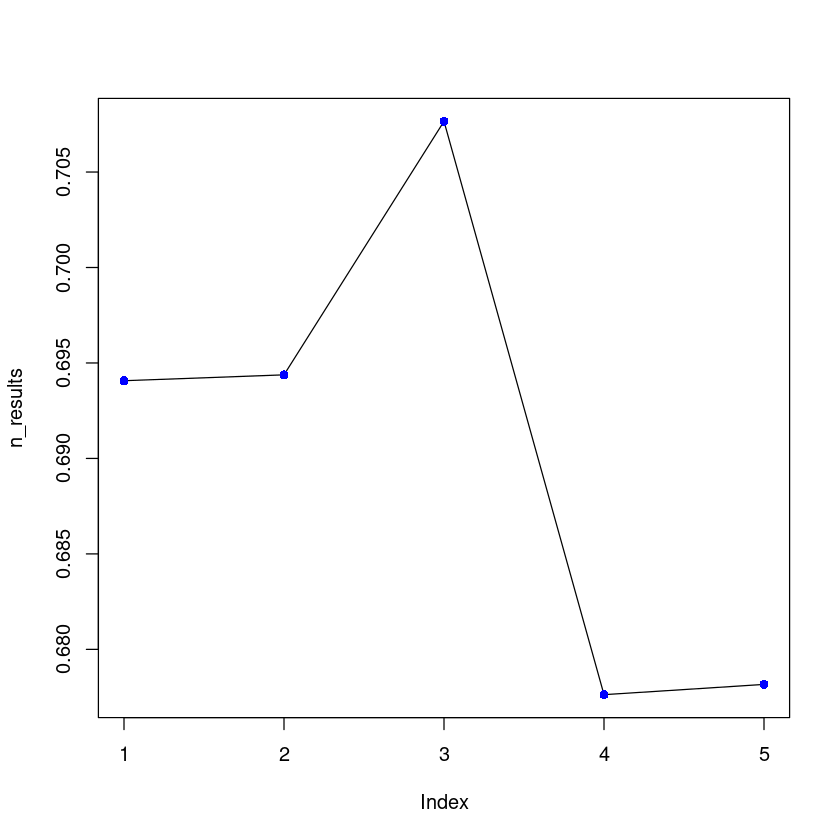

In [60]:
plot(n_results, type = "l")
points(n_results, col = "blue", pch = 16)

As we can see the best outcome comes from the top 20 features. From this point onwards when using k nearest neighbour we are going to select the top 20 features.

In [38]:
feature_n <- 20

We will iterate through a different set of `k`, so we can assert which number of `k` gives the best outcome.

In [33]:
k_results <- numeric(5)

i <- 1
for (k in c(11,14,17,22,25)){
    knn_model <- knn(knn_train_set[,selected[1:feature_n]], knn_test_set[,selected[1:feature_n]], response[knn_train_indices], k = k)
    metrics <- get_metrics(knn_model, response[-knn_train_indices])
    k_results[i] <- metrics$accuracy
    i <- i+1
}

Plot the outcome of the calculation

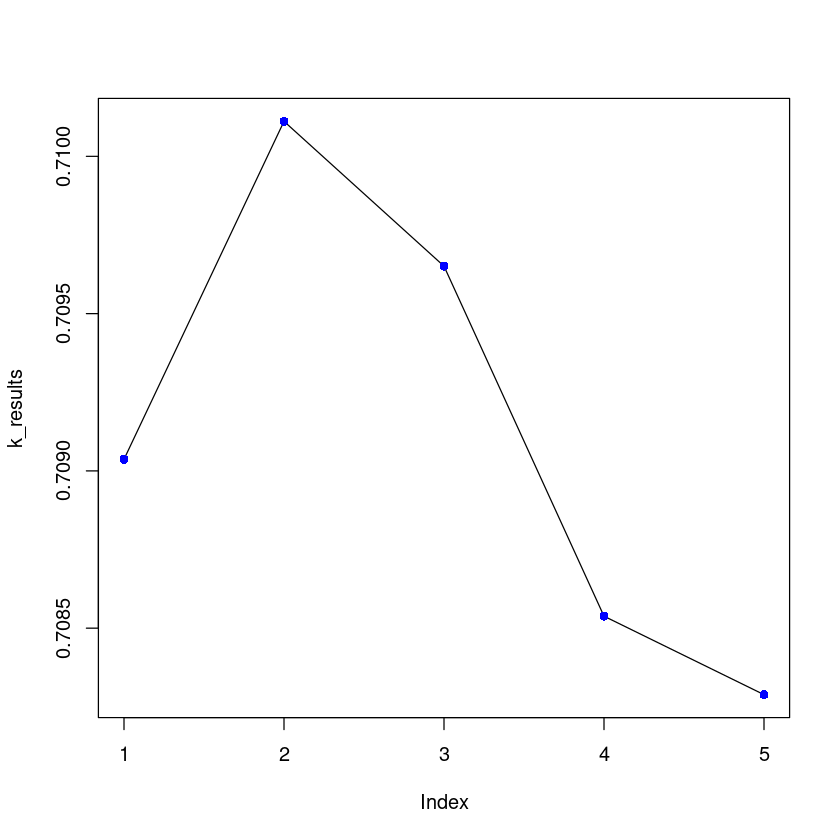

In [34]:
plot(k_results, type = "l")
points(k_results, col = "blue", pch = 16)

As we can see the best outcome comes from `k` equals to 14. From this point onwards when using k nearest neighbour we are going to use `k` = 14.

In [37]:
k <- 14

Now that we have the best `k` and `n`, we can test it on the data.

In [31]:
knn_model <- knn(knn_train_set[,selected[1:feature_n]], knn_test_set[,selected[1:feature_n]], response[knn_train_indices], k = k)

We can have some metrics on how precise the classification is.

          labels
prediction     1     2     3
         1  1988  1139   114
         2  2852 24112  6516
         3   193  4250 10956

[1] "Accuracy:  0.710974673829624"
[1] "Precision: "


[1] 0.6133909 0.7201912 0.7114748

[1] "Recall: "


[1] 0.3949930 0.8173282 0.6229956

[1] "Specificity: "


[1] 0.9733897 0.5858349 0.8713442

[1] "F1_score: "


[1] 0.4805415 0.7656912 0.6643020

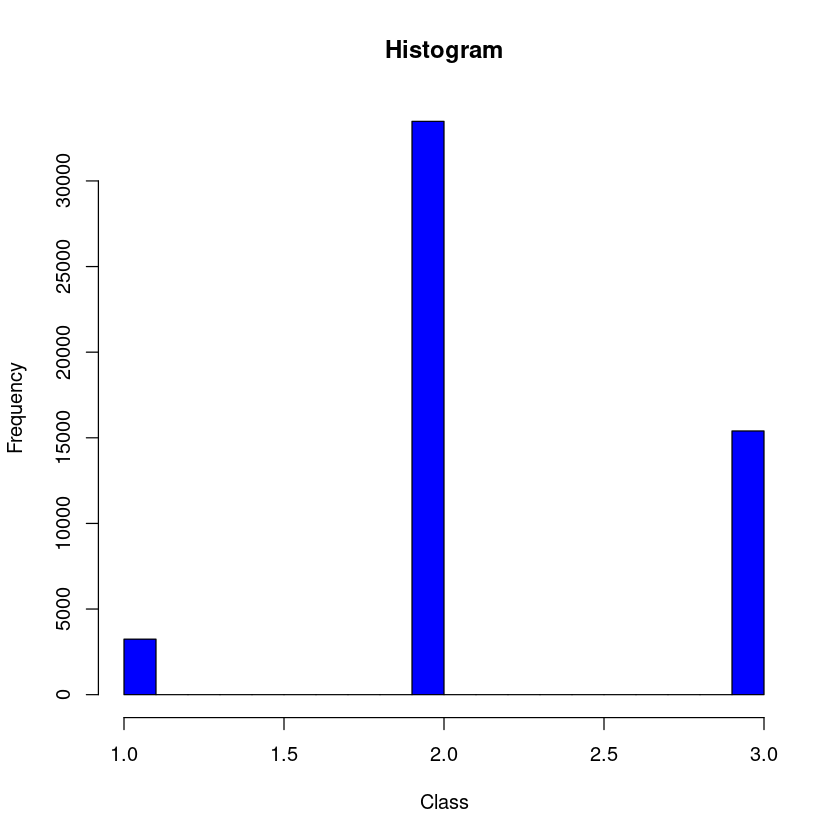

In [32]:
metrics <- get_metrics(knn_model, response[-knn_train_indices])
metrics$confusion_matrix
print(paste("Accuracy: ", metrics$accuracy))
print("Precision: ")
metrics$precision
print("Recall: ")
metrics$recall
print("Specificity: ")
metrics$specificity
print("F1_score: ")
metrics$f1_score

hist(as.numeric(knn_model), breaks = "Sturges", col = "blue", xlab = "Class", ylab = "Frequency", main = "Histogram")

## Model selection
We want to select multiple model for the next point. Our criteria for selection is based on the metrics of the model. For this purpose we choose the `knn` and `decision tree`.
Even though the `decision tree` is not able to classify correctly the first class, we wanted to keep in consideration its capability regarding the other metrics, like *recall* and *Specificity*.

# Task 3 - Different classification model(s)
## Gradient Boosting

Here we select which row use for train and which for test.

In [45]:
gb_train_indices <- sample(1:nrow(data), round(0.7*nrow(data)), replace = FALSE)
gb_train_set <- data[gb_train_indices,]
gb_test_set <- data[-gb_train_indices,]
head(gb_train_set)
head(gb_test_set)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
186660,806328,8,1184,11643,2,20,13,6,3,3,⋯,0,0,0,0,0,0,0,0,0,0
109975,117563,10,735,9103,2,5,5,4,3,3,⋯,0,0,0,0,0,0,0,0,0,0
178776,553178,17,682,9192,3,0,10,6,3,3,⋯,0,0,0,0,0,0,0,0,0,0
197372,966240,6,852,10178,2,20,10,7,1,3,⋯,0,1,0,0,0,0,0,0,0,0
229434,574050,6,96,6903,3,20,7,7,3,3,⋯,0,0,0,0,0,0,0,0,0,0
105488,418481,3,175,5128,4,85,10,8,3,3,⋯,0,0,0,0,0,0,0,0,0,0


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
4,590882,22,418,10694,2,10,6,5,3,3,⋯,0,0,0,0,0,0,0,0,0,0
5,201944,11,131,1488,3,30,8,9,3,3,⋯,0,0,0,0,0,0,0,0,0,0
7,728451,9,475,12066,2,25,3,4,1,3,⋯,0,0,0,0,0,0,0,0,0,0
9,441126,0,757,7219,2,15,8,6,3,3,⋯,0,0,0,0,0,0,0,0,0,0
10,989500,26,886,994,1,0,13,4,3,2,⋯,0,0,0,0,0,0,0,0,0,0
12,452227,17,1275,4004,1,10,8,4,3,4,⋯,0,0,0,0,0,0,0,0,0,0


Hyperparameters optimized for multiclass classification.
**Here is important that you have the xgboost with the GPU feature enable, otherwise it will not work.**

In [47]:
xgb_params <- list(
  booster = "gbtree",
  eta = 0.02,
  max_depth = 30,
  gamma = 0.9,
  subsample = 0.9,
  colsample_bytree = 0.7,
  objective = "multi:softprob",
  sampling_method = "gradient_based",
  eval_metric = "auc",
  num_class = 3,
  max_delta_step = 6,
  nthread = 6,
  predictor = "gpu_predictor",
  tree_method = 'gpu_hist'
)

We are going to test which number of features gives the best accuracy on classification.
In this case we don't need to train the model for a high number of rounds, because we just need and indication of the overall performance.

In [41]:
xgb_results <- numeric(6)

index <- 1
for (n in c(15,17,20,22,25,length(selected))){
    xgb_train <- xgb.DMatrix(data = as.matrix(gb_train_set[, selected[1:n]]), label = response[gb_train_indices] - 1)
    xgb_model <- xgb.train(
      params = xgb_params,
      data = xgb_train,
      nrounds = 1000,
      verbose = 0,
    )
    xgb_preds_test <- predict(xgb_model, as.matrix(gb_test_set[,selected[1:n]]), reshape = TRUE)
    xgb_preds_test <- as.data.frame(xgb_preds_test)
    Y_hat_test <- {}
    for (i in 1:nrow(xgb_preds_test)){
        Y_hat_test[i] <- which(xgb_preds_test[i,] == max(as.numeric(xgb_preds_test[i,])))
    }
    metrics <- get_metrics(Y_hat_test, response[-gb_train_indices])
    xgb_results[index] <- metrics$accuracy
    index <- index+1
}

Plot the outcome of the calculation

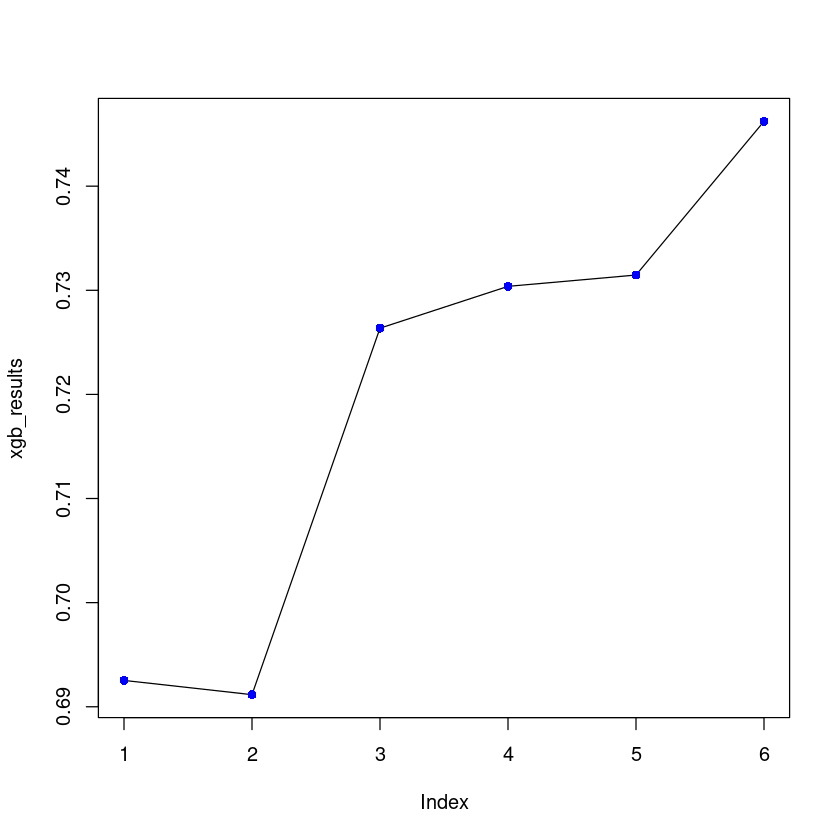

In [47]:
plot(xgb_results, type = "l")
points(xgb_results, col = "blue", pch = 16)

As we can see, having the entire number of features gives the best precision. From this point onwards when using gradient boosting we are going to use the entire set of features.

In [48]:
feature_xgb <- length(selected)

We train the model on the `xgb_train` data with `xgb_params` hyperparameters.

In [49]:
xgb_train <- xgb.DMatrix(data = as.matrix(gb_train_set[, selected[1:feature_xgb]]), label = response[gb_train_indices] - 1)
xgb_model <- xgb.train(
  params = xgb_params,
  data = xgb_train,
  nrounds = 20000,
  verbose = 0,
)
xgb_model

##### xgb.Booster
raw: 129.9 Mb 
call:
  xgb.train(params = xgb_params, data = xgb_train, nrounds = 20000, 
    verbose = 0)
params (as set within xgb.train):
  booster = "gbtree", eta = "0.02", max_depth = "30", gamma = "0.9", subsample = "0.9", colsample_bytree = "0.7", objective = "multi:softprob", sampling_method = "gradient_based", eval_metric = "auc", num_class = "3", max_delta_step = "6", nthread = "6", predictor = "gpu_predictor", tree_method = "gpu_hist", validate_parameters = "TRUE"
xgb.attributes:
  niter
# of features: 38 
niter: 20000
nfeatures : 38 

We test our model seeing what will be the prediction and testing the accuracy

In [50]:
xgb_preds_test <- predict(xgb_model, as.matrix(gb_test_set[,selected[1:feature_xgb]]), reshape = TRUE)
xgb_preds_test <- as.data.frame(xgb_preds_test)
Y_hat_test <- {}
for (i in 1:nrow(xgb_preds_test)){
    Y_hat_test[i] <- which(xgb_preds_test[i,] == max(as.numeric(xgb_preds_test[i,])))
}

We can have some metrics on how precise the classification is.

          labels
prediction     1     2     3
         1  3821  1432   135
         2  3569 38090  9704
         3    97  4810 16522

[1] "Accuracy:  0.747416218981837"
[1] "Precision: "


[1] 0.7091685 0.7415844 0.7710112

[1] "Recall: "


[1] 0.5103513 0.8591988 0.6267592

[1] "Specificity: "


[1] 0.9778337 0.6078646 0.9053050

[1] "F1_score: "


[1] 0.5935534 0.7960709 0.6914417

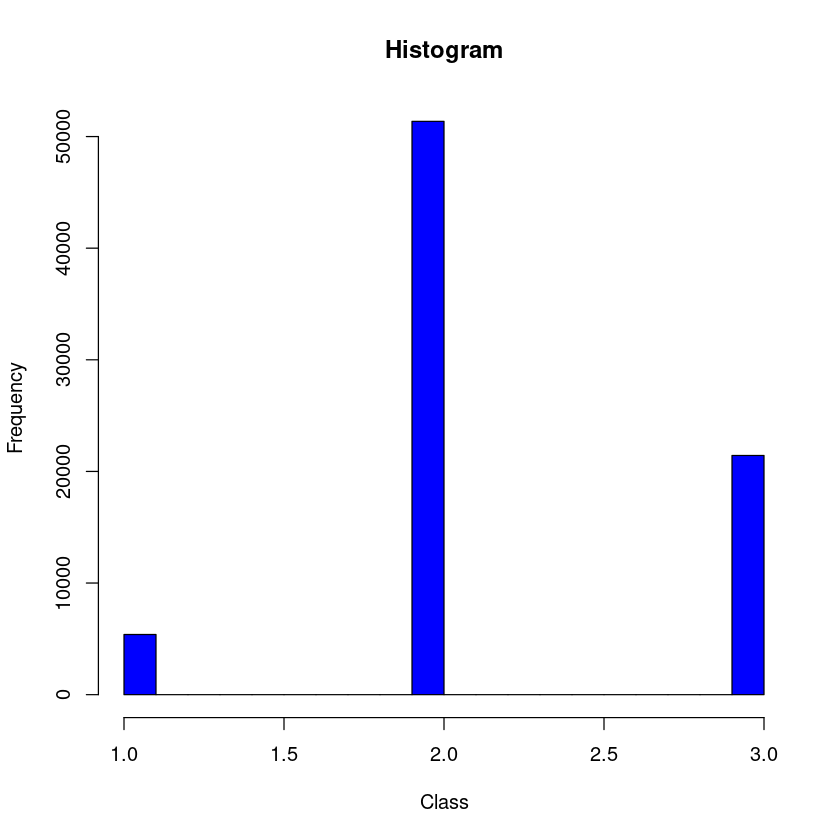

In [51]:
metrics <- get_metrics(Y_hat_test, response[-gb_train_indices])
metrics$confusion_matrix
print(paste("Accuracy: ", metrics$accuracy))
print("Precision: ")
metrics$precision
print("Recall: ")
metrics$recall
print("Specificity: ")
metrics$specificity
print("F1_score: ")
metrics$f1_score

hist(as.numeric(Y_hat_test), breaks = "Sturges", col = "blue", xlab = "Class", ylab = "Frequency", main = "Histogram")

We can see that gradient boosting is a good classifier, as its accuracy is the highest.

## Model mixing
We are going to mix multiple model prediction in order to have the most accurate outcome.
In this case we are going to use `knn`, `gradient boosting`, `decision tree`.

We define methods to use

In [52]:
majority_mix <- function(x) {
    A <- x[1]
    B <- x[2]
    C <- x[3]
    # Since decision tree doesn't predict one i'm gonna focus on the other two
    # Since knn and xgb have the same specificity i'm going to trust the prediction only if both of them says that the calssification is not 1
    if(A == 1 | C == 1){
      return(1)
    }
    # The precision of tree and xgb on 3 is higher on the precision compared to knn, so for this reason we are going to take 3 as classificaiton
    if(B == 3 | C == 3){
      return(3)
    }
    return(2)
}
get_mix_prediction <- function(tree_model, xgb_model, train_set, test_set, train_label, features, k, n, feature_xgb) {
    tree_mix_pred <- predict(tree_model, newdata = test_set, type = "class")
    xgb_mix_preds <- predict(xgb_model, as.matrix(test_set[features[1:feature_xgb]]), reshape = TRUE)
    knn_mix_pred <- knn(train_set[features[1:n]], test_set[features[1:n]], train_label, k = k)
    xgb_class_mix <- {}
    for (i in 1:nrow(xgb_mix_preds)){
        xgb_class_mix[i] <- which(xgb_mix_preds[i,] == max(as.numeric(xgb_mix_preds[i,])))
    }
    Y_comb <- cbind(knn_mix_pred,as.numeric(tree_mix_pred), xgb_class_mix)
    Y_mix <- apply(Y_comb, 1, majority_mix)
    return(Y_mix)
}

We test the mix prediction on the test data

In [53]:
mix_train_indices <- sample(1:nrow(data), round(0.7*nrow(data)), replace = FALSE)
Y_mix_test <- get_mix_prediction(tree_model = tree_model, xgb_model = xgb_model, train_set = data[mix_train_indices,], test_set = data[-mix_train_indices,],
                            train_label = response[mix_train_indices], features = selected, k = k, n = feature_n, feature_xgb = feature_xgb)


We can have some metrics on how precise the classification is.

          labels
prediction     1     2     3
         1  5297  1982   223
         2  2185 37654  6800
         3   101  4745 19193

[1] "Accuracy:  0.794883601944231"
[1] "Precision: "


[1] 0.7060784 0.8073501 0.7984109

[1] "Recall: "


[1] 0.6985362 0.8484261 0.7321102

[1] "Specificity: "


[1] 0.9687664 0.7341637 0.9067431

[1] "F1_score: "


[1] 0.7022870 0.8273786 0.7638245

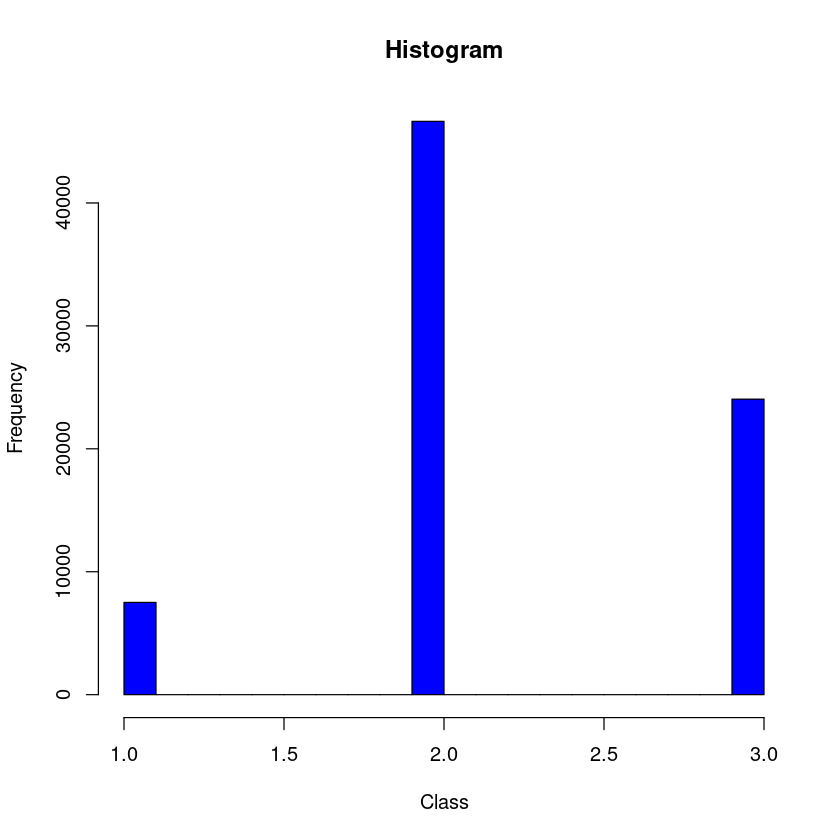

In [54]:
metrics <- get_metrics(Y_mix_test, response[-mix_train_indices])
metrics$confusion_matrix
print(paste("Accuracy: ", metrics$accuracy))
print("Precision: ")
metrics$precision
print("Recall: ")
metrics$recall
print("Specificity: ")
metrics$specificity
print("F1_score: ")
metrics$f1_score

hist(as.numeric(Y_mix_test), breaks = "Sturges", col = "blue", xlab = "Class", ylab = "Frequency", main = "Histogram")

#### Prediction on real data

In [55]:
Y_mix <- get_mix_prediction(tree_model = tree_model, xgb_model = xgb_model, train_set = data, test_set = test_values,
                            train_label = response, features = selected, k = k, n = feature_n, feature_xgb = feature_xgb)

# Task 4 - Drivendata evaluation

### Mix model prediction
here we are going to use a combination of models for the evaluation of the final value.

In [56]:
driven_data_csv <- data.frame(building_id = test_values[,1], damage_grade = Y_mix)
write.csv(driven_data_csv, "output_mix.csv", row.names = FALSE)

In Drivendata has scored `0.7243` with the file `output_mix_most_common.csv` as in this prediction we have taken the most common result out of the mix predictions.
In Drivendata has scored `0.7319` with the file `output_mix_1_priority.csv` as in this prediction we have taken the most common result and give priority to the class 1 out of the mix predictions.
In Drivendata has scored `0.7325` with the file `output_mix_79.csv` as in this prediction we have modified the model classification selection.

### Xgboost model prediction
here we are going to use the xgboost model for the evaluation of the test data.

In [59]:
xgb_preds <- predict(xgb_model, as.matrix(test_values[, selected]), reshape = TRUE)
xgb_preds <- as.data.frame(xgb_preds)
Y_hat <- {}
for (i in 1:nrow(xgb_preds)){
    Y_hat[i] <- which(xgb_preds[i,] == max(as.numeric(xgb_preds[i,])))
}
driven_data_csv <- data.frame(building_id = test_values[,1], damage_grade = Y_hat)
write.csv(driven_data_csv, "output_xgboost.csv", row.names = FALSE)

In Drivendata has scored `0.7460` with the file `output_xgboost.csv`.

Even though the model mix prediction had a better accuracy on the test data compared to the gradient boosting, it could be that our selection method on the model mix is overfitting, hence heading into a lower value score.

# Task 5 - Entropy

In [15]:
entropy <- function(x) {
  p <- table(x) / length(x)
  -sum(p * log2(p))
}
transform_xgb <- function(x){
    hat <- {}
    for (i in 1:nrow(x)){
        hat[i] <- which(x[i,] == max(as.numeric(x[i,])))
    }
  return(hat)
}

Since we are going to calculate the conditional entropy by subtracting a specific column, to achieve this we need to train the model on that specific subset of data.
For this reason in this following code cell we are going to create a baseline for training and testing.

In [18]:
ce_train_indices <- sample(1:nrow(data), round(0.7*nrow(data)), replace = FALSE)
ce_train_set <- data[ce_train_indices, selected]
ce_test_set <- data[-ce_train_indices, selected]
ce_xgb_train <- xgb.DMatrix(data = as.matrix(ce_train_set), label = response[ce_train_indices] - 1)
ce_xgb_params <- list(
  booster = "gbtree",
  eta = 0.02,
  max_depth = 30,
  gamma = 0.9,
  subsample = 0.9,
  colsample_bytree = 0.7,
  objective = "multi:softprob",
  sampling_method = "gradient_based",
  eval_metric = "auc",
  num_class = 3,
  max_delta_step = 6,
  nthread = 6,
  predictor = "gpu_predictor",
  tree_method = 'gpu_hist'
)
ce_xgb_model <- xgb.train(
  params = ce_xgb_params,
  data = ce_xgb_train,
  nrounds = 5000,
  verbose = 0,
)

**WARNING**
this computation takes a long time

With this code cell we are going to compute the conditional entropy of each feature. The output can be seen in the output of this cell or inside the file `conditional_entropy.csv`.
For computational reason we choose to step back on the gradient boosting, modifying the number of rounds to be less computationally expensive. That is because the difference in precision between gradient boosting and the model_mix is not so marked.

In [38]:
results <- numeric(ncol(ce_test_set))

# Compute H(y|X)
prob_y_given_X <- predict(ce_xgb_model, as.matrix(ce_test_set), reshape = TRUE)
H_y_X <- entropy(transform_xgb(prob_y_given_X))
print(paste("Base Entropy: ", H_y_X))

# Iterate over all columns except the target column
for(i in 1:ncol(ce_test_set)){

    # Get the dataset without the column i
    new_dataset <- ce_test_set[, -i]

    # Train the model on the new data without the column
    ce_xgb_train_wo_col <- xgb.DMatrix(data = as.matrix(subset(ce_train_set, select=-c(i))), label = response[ce_train_indices] - 1)
    ce_xgb_model_wo_col <- xgb.train(
      params = ce_xgb_params,
      data = ce_xgb_train_wo_col,
      nrounds = 5000,
      verbose = 0,
    )

    # Compute H(y|X^(−i))
    prob_y_given_X_minus_i <- predict(ce_xgb_model_wo_col, as.matrix(new_dataset), reshape = TRUE)
    H_y_X_minus_i <- entropy(transform_xgb(prob_y_given_X_minus_i))

    # Compute the result
    results[i] <- H_y_X_minus_i - H_y_X
}

# Features and relevance dataframe
features_ranking <- data.frame(Feature = names(ce_test_set), Relevance = results)

# Sort the data frame in desending order
features_ranking <- features_ranking[order(-features_ranking$Relevance), ]

print(features_ranking)

[1] "Base Entropy:  1.17099198508451"
                                  Feature     Relevance
13                        area_percentage  2.361450e-03
37          has_secondary_use_agriculture  2.183038e-03
21                                    age  1.658906e-03
33           has_secondary_use_gov_office  1.609085e-03
9                               roof_type  1.468603e-03
16                has_secondary_use_hotel  1.426736e-03
35                       other_floor_type  1.407701e-03
3        has_superstructure_rc_engineered  1.136951e-03
23                      has_secondary_use  1.088454e-03
32          has_secondary_use_health_post  9.963219e-04
17               has_secondary_use_rental  9.669481e-04
7                       ground_floor_type  9.621006e-04
26               has_superstructure_other  9.088181e-04
27                 land_surface_condition  6.808319e-04
8            has_superstructure_adobe_mud  6.211582e-04
5                         foundation_type  5.555542e-04
36        

The result of the conditional entropy gives us the ranking of the most informative features on the output based on our classifier, in this case gradient boosting.
The list goes from the less informative to the most informative.